## Kalman Filter & 3D Experiment

In [1]:
# Import aller benötigten Module
%matplotlib notebook
# Eigene Module
from DataGenerationRadar3D import *
from DBScan import *
from Widgets3D import *
# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual
import ipywidgets as widgets

In [2]:
class abFilter:
    def __init__(self, x_0, dx, a, b, dt):
        self.x_est = x_0 # initial state value
        self.dx = dx # inital change rate
        self.a = a # a scale factor
        self.b = b # b scale factor
        self.dt = dt # time step
    
    def step(self, values):
        ests = []
        preds = []
        for z in values:
            # Predict
            x_pred = self.x_est + (self.dx * self.dt)
            preds.append(x_pred)
            self.dx = self.dx
            # Update
            residual = z - x_pred
            self.dx += self.b * (residual)/self.dt
            self.x_est = x_pred + self.a * residual
            ests.append(self.x_est)
        return np.array(ests), np.array(preds)

Um ein besseres Verständis für das Kalman Filter zu erlangen, haben wir uns zunächst mit der Theorie dahinter beschäftigt. Im Zuge dieses Prozesses sind wir auf den $\alpha$-$\beta$-Filter gestoßen. Der $\alpha$-$\beta$-Filter bildet die Grundlage für eine Reihe von Filtern, darunter auch das Kalman Filter. Wir haben uns daher dazu entschlossen, diesen zu Übungszwecken zu implementiert.

In unserem Beispiel verwenden wir den Filter dazu, das Körpergewicht einer Person vorherzusagen.

Unser Filter verwendet dazu folgende Parameter:
* `x_0` als initialen Zusatandswert (in unserem Fall das Anfangsgewicht)
* `dx` als initiale Änderungsrate des Gewichts z. B. +0.5 kg/Tag
* `a` als Faktor für die Veränderung der Gewichtsmessung
* `b` als Faktor für die Änderungsrate des Gewichts
* `dt` für das Zeitintervall

sowie `values` für unsere Messwerte.

Nachdem der $\alpha$-$\beta$-Filter initialisiert wurde, führt er folgende Schritte aus:

1. Berechnung der Vorhersage im nächsten Zeitintervall basierend auf aktuellem Schätzwert, Änderungsrate und Zeitintervall
2. Berechnen der Differenz aus aktuellem Messwert und Vorhersage
3. Anpassung der neuen Änderungsrate mit Faktor `b`, des Restwerts aus Schritt 2 und dem Zeitintervall
4. Berechnung des neuen Schätzwerts mittels Vorhersage, Faktor `a` und Restwert

Um den Filter zu testen haben wir mittels einer Funktion 14 Messwerte generiert und diese an den Filter übergeben. Zur Initialisierung haben wir zudem 86 kg, einen Änderungsrate von +1 kg/Tag, einen $\alpha$-Wert von 0.4 und einen $\beta$-Wert von 0.2 und einen Zeitintervall von 1 übergeben. Auf passende Werte für `a` und `b` sind wir durch ausprobieren gestoßen.

<IPython.core.display.Javascript object>


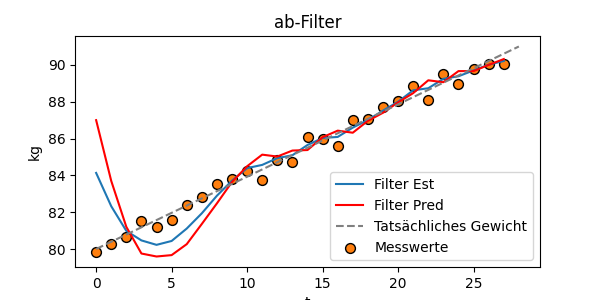

In [3]:
# Daten: Körpergewichte über n Tage verteilt gemessen
count = 28
def data_generator(x_0, dx, count, noise_factor):
    return [x_0 + dx * i + np.random.randn() * noise_factor for i in range(count)]

gewichte = data_generator(79.9, 0.4, count, 0.3) # kg
#print(gewichte)
zeitabstaende = [i for i in range(28)] # n Tage
print()
# Initialisierung und Ausführung des ab-Filters
gewicht_filter = abFilter(x_0=86, dx=1, a=0.4, b=0.2, dt=1.)
pr = gewicht_filter.step(values=gewichte)

# Ploten der Filter Ergebnisse im Vergleich zu den den echten Werten
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(pr[0], label='Filter Est')
ax.plot(pr[1], label='Filter Pred', color='r')
ax.scatter(zeitabstaende, gewichte, s=50, facecolor='C1', edgecolor='k', label='Messwerte')
ax.plot([0,count], [80., 91.], label='Tatsächliches Gewicht', linestyle='--', color='grey')
ax.set_xlabel('t')
ax.set_ylabel('kg')
ax.set_title("ab-Filter")
ax.legend()

Die von uns gewählte initiale Schätzung von 86 kg war mit Absicht sehr hoch gewählt. Wir sehen daher einen großen Ausschlag zu Beginn, schließlich benötigt der Filter einige Iterationen, um sein Werte anzupassen, so dass der Filter zum Ende hin eine deutlich bessere Schätzung ausgiebt.

### Das Kalman Filter

Das Kalman Filter ist ein Algorithmus, der anhand einer Reihe von Messungen über eine gewisse Zeit unbekannte Variablenwerte eines Systems schätzt. Dabei versucht das Filter Unsicherheiten durch statistisches Rauschen und den Einbezug eines zu Grunde liegenden physiklasichen Modells zu reduzieren.

In unserem Fall versuchen wir mit das Kalman Filter die Position eines Objekts erst im eindimensionalen Raum, dann in einem dreidimensionalen Raum vorherzusagen,. Die Messwerte liefert uns dabei eine Radarsensor Simulation.

Die Klasse `KalmanFilter` implementiert das Kalman Filter und besteht aus zwei Methoden. Über die `__init__(self, s_hat, transition_model, H, Q, R)` Methode kann das Kalman Filter mit folgenden Parametern initialisiert werden:
* `s_hat` ist die Position des Objekts im Raum (x, y, z Koordianten)
* `P_hat` ist die Kovarianz des Zustands
* `model/transition_model` ist das zu Grunde liegene physikalische Modell
* `H` ist die Messfunktion
* `Q` beschreibt das Prozessrauschen
* `R` beschreibt das Messrauschen

Nach der Initialisierung kann die `step(self,z)` Funktion mit den Messwerten `z` aufgerufen werden, um den Kalman Algorithmus auszuführen. 

In [4]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
    
    def step(self, z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T + self.Q
        # Calculate Kalman Gain
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        return self.s_hat

Im Detail führt die `step(self,z)` Methode dann folgende Schritte nacheinander aus:

1. Vorhersage der neuen Position durch `s_hat_p = self.model @ self.s_hat`
2. Berechnung der Kovarianz des Zustands durch `P_hat_p = self.model @ self.P_hat @ self.model.T + self.Q`
3. Berechung des Kalman Gain durch `K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)`
4. Aktualisierung der Kovarianz des Zustands durch `self.P_hat = self.P_hat - K @ self.H @ self.P_hat`
5. Verbesserung der Schätzung durch `e_m_p = z - self.H @ s_hat_p` und `self.s_hat = s_hat_p + K @ e_m_p`

Zum Schluss wird die neu geschätzte Position zurückgegeben.

Um den Filter zu testen, initialisieren wir ihn mit folgenden Werten für `transition_model`, `Q`, `H`, `R`:

In [5]:
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1,    0.01  ],
                             [0, 0,    0.01 ]])
Q = np.diag([0.05, 0.05, 0.05])
H =  np.array([[1., 0., 0.]])
R = np.diag([rangeAccuracy**2])/3

Anschließend erstellen wir ein Objekt, welches wir mit das Filter verfolgen können:

In [6]:
path1 = [[0,   5, 0  ],
         [0,   5, 0.5],
         [1,   4, 1  ],
         [2,   3, 2  ],
         [1,   5, 3  ],
         [1,   5, 0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}

x = Target(opt1)

targets = [x]

Sowie den Radarsensor, welcher sich in unserem Fall an der Position `0, 0, 0.5` (x, y, z) befindet und einen Öffnungswinkel von 120 Grad horizontal und 90 Grad vertikale besitzt.

In [7]:
optRadar = {
    'Position' : np.array([0, 0, 0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

Nun iterieren wir über die *targets* und plotten anschließend das Ergbenis. Wir nutzen dabei, wie zuvor beschrieben den DBScan Algorithmus um die *Detections* des Radar Sensors in Cluster zu ordnen.
Für jedes Objekt wird ein Kalman Filter mit der esten Position des Objekts instanziert. Die Instanz wird anschließend dazu verwendet durch die *Detections* zu iterieren.

<IPython.core.display.Javascript object>


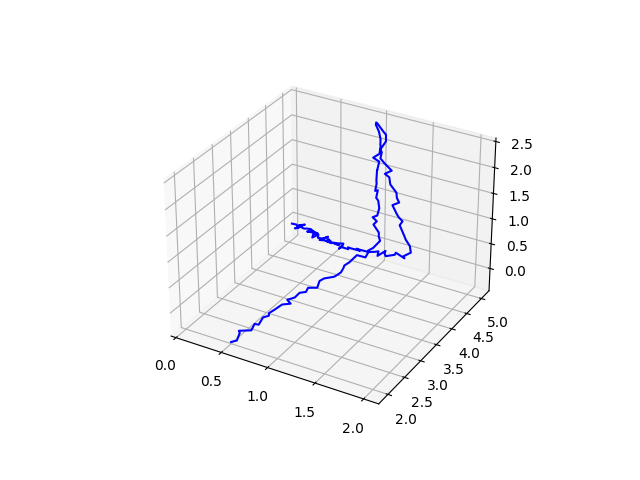

In [12]:
Detections = np.array([0,0,0])
model = DBSCAN(eps=0.2, minpts=2)
# Number of previous measurements to consider for DBSCAN().
ante = 20
# Count number of iterations
i = 0

getNext = True
while(getNext == True):
    i += 1
    for target in targets:
        target.Step(1/sensor.opt['MeasurementRate'])
        getNext = getNext & ~target.reachedEnd  

    dets = sensor.Detect(targets)
    # Exclude radialVelocity for the moment. (todo: include it.)
    for det in dets:
        det = det[:-1]
        Detections = np.vstack((det, Detections))
    
    # Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
    if i == ante:
        # First application of DBSCAN.
        clusters = model.fit_predict(Detections[:ante])
        # Determine number of targets (objects tracked).
        num_objs = len(set(clusters[clusters > -1]))
        
        # "Filters" contains a kalman filter for each target.
        Filters = []
        # "Preds" contains the predictions of the path of each target.
        Preds = []
        # Iterate over the targets.
        for j in range(num_objs):
            # Find index of first occurence of target j in clusters.
            # This line is needed to filter out false detections
            obj_idx = np.where(clusters == j)[0][0]
            # Add placeholder values for speed and acceleration in each component to the detection.
            s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
            Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
            # For the moment only the predicted position is relevant. todo: incorporate velocity.
            Preds.append(s0[0,:])

    # Cluster and predict position via Kalman filter.
    elif i > ante:
        clusters = model.fit_predict(Detections[:ante])
        for j in range(num_objs):
            # try/ except prevents non-detection of existing object from breaking the program.
            try:
                obj_idx = np.where(clusters == j)[0][0]
                # Reshape is needed to make matrix multiplication inside the kalman filter work.
                s = Detections[obj_idx].reshape(1,3)
                s_hat = Filters[j].step(s)
                Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
            except IndexError:
                print(f"Object {j} not found!")
                continue

# Visualize trajectory.
T1 = Preds[0][:-1]

# Plot Trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')   
#ax.view_init(20, 35) 
ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'blue')

### Interaktives 3D Experiment

Im folgenden Abschnitt besteht die Möglichkeit selbst die verschiedenen Parameter des Experiments anzupassen und das dadurch entstehende Ergebnis zu beobachten.

In [10]:
def update(eps, minpts, targ_select, plt_fdets):
    
    # initialize DBScan
    model = DBSCAN(eps, minpts)
    
    # clear graph on update
    ax.clear()
    
    # Parameters first target
    path1 = [[0,5,0],
            [0,5,0.5],
            [1,5,1],
            [1,5,0.5],
            [0.5, 2, 0.1]]
    
    vel1 = 3 * np.ones((1,5))
    vel1[0,2] = 1

    InitialPosition1 = np.array([-1,5,0])

    opt1 = {
        'InitialPosition' : InitialPosition1,
        'Path' : np.array(path1).transpose(),
        'Velocities' : vel1
    }
    
    # Parameters second target
    path2 = [[1. , 4. , 1. ],
             [1. , 5. , 1.7],
             [2. , 5. , 1. ],
             [3. , 4. , 2. ],
             [3. , 4. , 1.5],
             [2. , 4. , 2. ]]

    vel2 = 2 * np.ones((1,len(path2)))
    vel2[0,4] = 0.5

    InitialPosition2 = np.array([2,4,1])

    opt2 = {
        'InitialPosition' : InitialPosition2,
        'Path' : np.array(path2).transpose(),
        'Velocities' : vel2
    }

    # Parameters third target
    path3 = [[1. , 4. , 1. ],
             [1. , 5. , 1.],
             [2. , 5. , 1. ],
             [3.5 , 4. , 2. ],
             [3. , 4.1 , 1.],
             [2.2 , 4. , 2. ]]

    vel3 = 2 * np.ones((1,len(path3)))
    vel3[0,4] = 0.3

    InitialPosition3 = np.array([3,4,5])

    opt3 = {
        'InitialPosition' : InitialPosition3,
        'Path' : np.array(path3).transpose(),
        'Velocities' : vel3
    }
    
    # Parameters fourth target
    path4 = [[1.5 , 4.2 , 1.5 ],
             [1.5 , 5.2 , 1.2],
             [2.5 , 5.2 , 1.2 ],
             [3.5 , 4.2 , 2.2 ],
             [3.5 , 4.1 , 1.4],
             [2.2 , 4.2 , 2.3 ]]

    vel4 = 2 * np.ones((1,len(path4)))
    vel4[0,4] = 0.7

    InitialPosition4 = np.array([4,4,4])

    opt4 = {
        'InitialPosition' : InitialPosition4,
        'Path' : np.array(path4).transpose(),
        'Velocities' : vel4
    }
    
    # Instantiate targets
    t_1 = Target(opt1)
    t_2 = Target(opt2)
    t_3 = Target(opt3)
    t_4 = Target(opt4)
    
    # Target and colors dictionary for interact
    target_dict = {'Target 1': t_1, 'Target 2': t_2, 'Target 3': t_3, 'Target 4': t_4}
    target_colors = {'Target 1': 'limegreen', 'Target 2': 'darkcyan', 'Target 3': 'darkviolet', 'Target 4': 'deeppink'}
    colors_list = []
    targets = list()
    
    # target selection for interact
    for target in targ_select:
        if target in target_dict:
            targets.append(target_dict[target])
            colors_list.append(target_colors[target])

    '''
    Setup the radar sensor
    The radar sensor points always to the direction along the y axis
    (see diagram in the note)
    '''
    
    sens_position = np.array([0,0,0.5])
    ax.plot3D(sens_position[0], sens_position[1], sens_position[2], 'ro')
    
    optRadar = {
        'Position' : sens_position,
        'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
        'FalseDetection': True
    }
    sensor = RadarSensor(optRadar)

    # Measurement error.
    ## Variance of a uniform distribution is given by (b-a)**2/12.
    R = np.diag([rangeAccuracy**2])/3
    # Process error.
    Q = np.diag([0.05,0.05,0.05])
    # Process/transition model.
    transition_model = np.array([[1, 0.01, 0.01/2],
                                 [0, 1, 0.01],
                                 [0, 0, 0.01]])
    # Transformation matrix
    ## Transforms predicted quantities into outputs that can be compared to the measurements
    H =  np.array([[1., 0., 0.]])


    getNext = True
    Detections = np.array([0,0,0])
    
    # Number of previous measurements to consider for DBSCAN().
    ante = 20
    # Count number of iterations
    i = 0
    
    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)

        # Allow display of false detections only with one target
        if len(targets) > 1:
            plt_fdets_ia.disabled=True
            plt_fdets_ia.value=False
        else:
            plt_fdets_ia.disabled=False

        # plot flase dets only if checkbox is activated and only one target selected
        if plt_fdets == True and len(targets) == 1:
            try:
                p = dets[1]
                ax.scatter(p[0], p[1], p[2], s=50, c='tomato')
            except IndexError:
                pass

        for det in dets:
            det = det[:-1]
            Detections = np.vstack((det, Detections))

        # Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
        if i == ante:
            # First application of DBSCAN.
            clusters = model.fit_predict(Detections[:ante])
            # Determine number of targets (objects tracked).
            num_objs = len(set(clusters[clusters > -1]))

            # "Filters" contains a kalman filter for each target.
            Filters = []
            # "Preds" contains the predictions of the path of each target.
            Preds = []
            # Iterate over the targets.
            for j in range(num_objs):
                # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]
                # Add placeholder values for speed and acceleration in each component to the detection.
                s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
                Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
                # For the moment only the predicted position is relevant. todo: incorporate velocity.
                Preds.append(s0[0,:])

        # Cluster and predict position via Kalman filter.
        elif i > ante:
            clusters = model.fit_predict(Detections[:ante])
            for j in range(num_objs):
                # try/ except prevents non-detection of existing object from breaking the program.
                try:
                    obj_idx = np.where(clusters == j)[0][0]
                    # Reshape is needed to make matrix multiplication inside the kalman filter work.
                    s = Detections[obj_idx].reshape(1,3)
                    s_hat = Filters[j].step(s)
                    Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
                except IndexError:
                    print(f"Object {j} not found!")
                    continue

    # Visualize trajectory.
    for pred, color in zip(Preds, colors_list):
        T = pred[:-1]
        ax.plot3D(T[:,0], T[:,1], T[:,2], color) 
    
    ax.set_xlim3d(0, 5)
    ax.set_ylim3d(0, 5)
    ax.set_zlim3d(0, 5)
    
    fig.canvas.draw_idle()

<IPython.core.display.Javascript object>


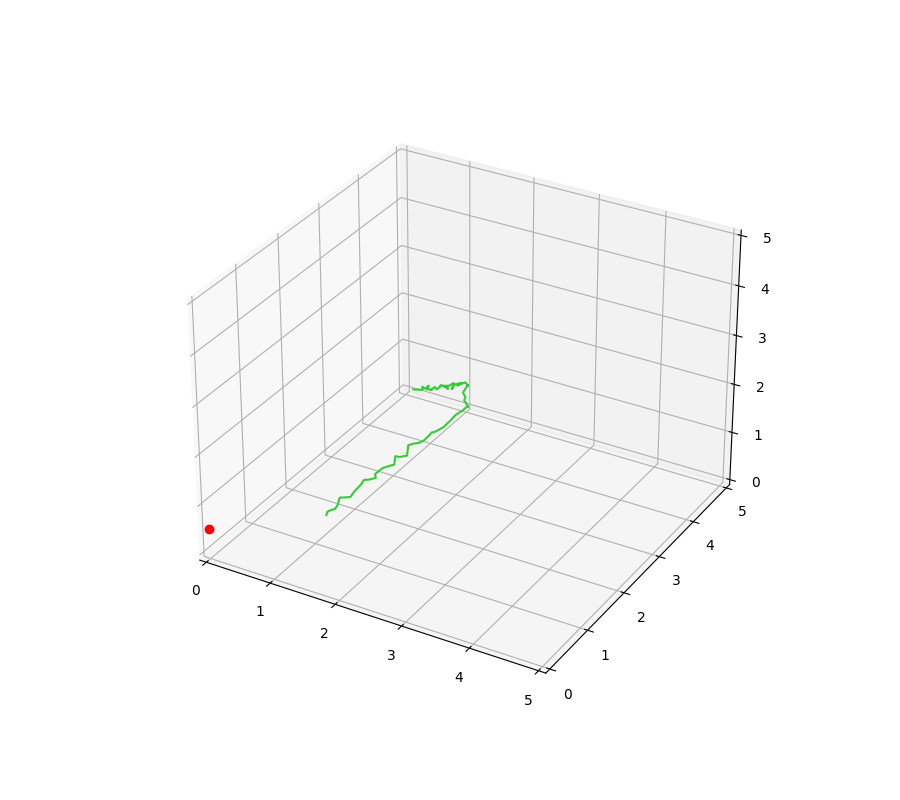

Output()

In [11]:
fig = plt.figure(figsize=(9, 8), dpi=100)
ax = plt.axes(projection='3d')

ui = widgets.VBox([eps_ia, 
                   minpts_ia, 
                   targets_ia,
                   plt_fdets_ia])
out = interactive_output(update, {'eps': eps_ia, 'minpts': minpts_ia, 'targ_select': targets_ia, 'plt_fdets': plt_fdets_ia})
display(ui, out)